In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import scipy

## load data

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)

In [4]:
pth_data = '../data/train.csv'
df_origin = pd.read_csv(pth_data)

In [5]:
df_origin

time  height  weight  gender        bmi  age  env_temp  \
0     2020-10-19 14:00:00    1.64    54.0       1  20.077335   24    77.990   
1     2020-10-19 14:30:00    1.64    54.0       1  20.077335   24    78.208   
2     2020-10-19 15:00:00    1.64    54.0       1  20.077335   24    78.514   
3     2020-10-19 15:30:00    1.64    54.0       1  20.077335   24    79.041   
4     2020-10-19 16:00:00    1.64    54.0       1  20.077335   24    79.435   
...                   ...     ...     ...     ...        ...  ...       ...   
2791  2020-10-28 21:30:00    1.63    50.0       1  18.818924   23    76.528   
2792  2020-10-28 22:00:00    1.63    50.0       1  18.818924   23    76.876   
2793  2020-10-28 22:30:00    1.63    50.0       1  18.818924   23    77.050   
2794  2020-10-28 23:00:00    1.63    50.0       1  18.818924   23    76.703   
2795  2020-10-28 23:30:00    1.63    50.0       1  18.818924   23    76.354   

          rh  heart_rate  stress_level  skin_temp       eda   TC   TS   Clo  \
0     62.122         NaN          17.0        NaN       NaN  4.0  4.0  0.74   
1     62.321         NaN          60.0     30.748  0.926320  4.0  4.0  0.74   
2     62.255         NaN          46.0     31.327  1.232405  4.0  4.0  0.74   
3     61.491         NaN          91.0     31.458  0.375005  4.0  4.0  0.74   
4     61.071         NaN          71.0     32.085  0.081127  4.0  4.0  0.74   
...      ...         ...           ...        ...       ...  ...  ...   ...   
2791  40.530        73.0          22.0     31.850  0.114876  2.0  3.0  0.50   
2792  39.890         NaN          10.0     32.215  0.146231  2.0  3.0  0.50   
2793  39.710         NaN           5.0     32.656  0.153838  2.0  3.0  0.50   
2794  39.980         NaN           0.0     31.902  0.160930  2.0  3.0  0.50   
2795  41.050         NaN           NaN     30.563  0.281910  2.0  3.0  0.50   

      Act  
0     1.0  
1     1.1  
2     1.1  
3     1.0  
4     1.0  
...   ...  
2791  1.0  
2792  1.0  
2793  1.0  
2794  1.0  
2795  1.0  

[2796 rows x 16 columns]

In [6]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2796 non-null   object 
 1   height        2796 non-null   float64
 2   weight        2796 non-null   float64
 3   gender        2796 non-null   int64  
 4   bmi           2796 non-null   float64
 5   age           2796 non-null   int64  
 6   env_temp      2796 non-null   float64
 7   rh            2796 non-null   float64
 8   heart_rate    1669 non-null   float64
 9   stress_level  1848 non-null   float64
 10  skin_temp     1874 non-null   float64
 11  eda           2396 non-null   float64
 12  TC            2717 non-null   float64
 13  TS            2712 non-null   float64
 14  Clo           2737 non-null   float64
 15  Act           2718 non-null   float64
dtypes: float64(13), int64(2), object(1)
memory usage: 349.6+ KB


## data process

### choose data: TS >= 3.0

In [7]:
df_origin[df_origin[['TS']].isna().TS].shape
# some na in clo, means unrecorded data

(84, 16)

In [8]:
df_record = df_origin[df_origin['TS'].isna() ^ True]

In [9]:
df_record.shape

(2712, 16)

In [10]:
df_comfort = df_record[df_record['TC'] >= 3.0]

### visualization

In [11]:
df_visual = df_comfort[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'TC', 'TS', 'Clo', 'Act', 'env_temp']]
# df_visual = df_comfort[['height', 'weight', 'gender', 'bmi', 'age']]

In [12]:
df_visual.head()

height  weight  gender        bmi  age      rh  heart_rate  stress_level  \
0    1.64    54.0       1  20.077335   24  62.122         NaN          17.0   
1    1.64    54.0       1  20.077335   24  62.321         NaN          60.0   
2    1.64    54.0       1  20.077335   24  62.255         NaN          46.0   
3    1.64    54.0       1  20.077335   24  61.491         NaN          91.0   
4    1.64    54.0       1  20.077335   24  61.071         NaN          71.0   

   skin_temp       eda   TC   TS   Clo  Act  env_temp  
0        NaN       NaN  4.0  4.0  0.74  1.0    77.990  
1     30.748  0.926320  4.0  4.0  0.74  1.1    78.208  
2     31.327  1.232405  4.0  4.0  0.74  1.1    78.514  
3     31.458  0.375005  4.0  4.0  0.74  1.0    79.041  
4     32.085  0.081127  4.0  4.0  0.74  1.0    79.435

#### pairplot
download it to zoom in

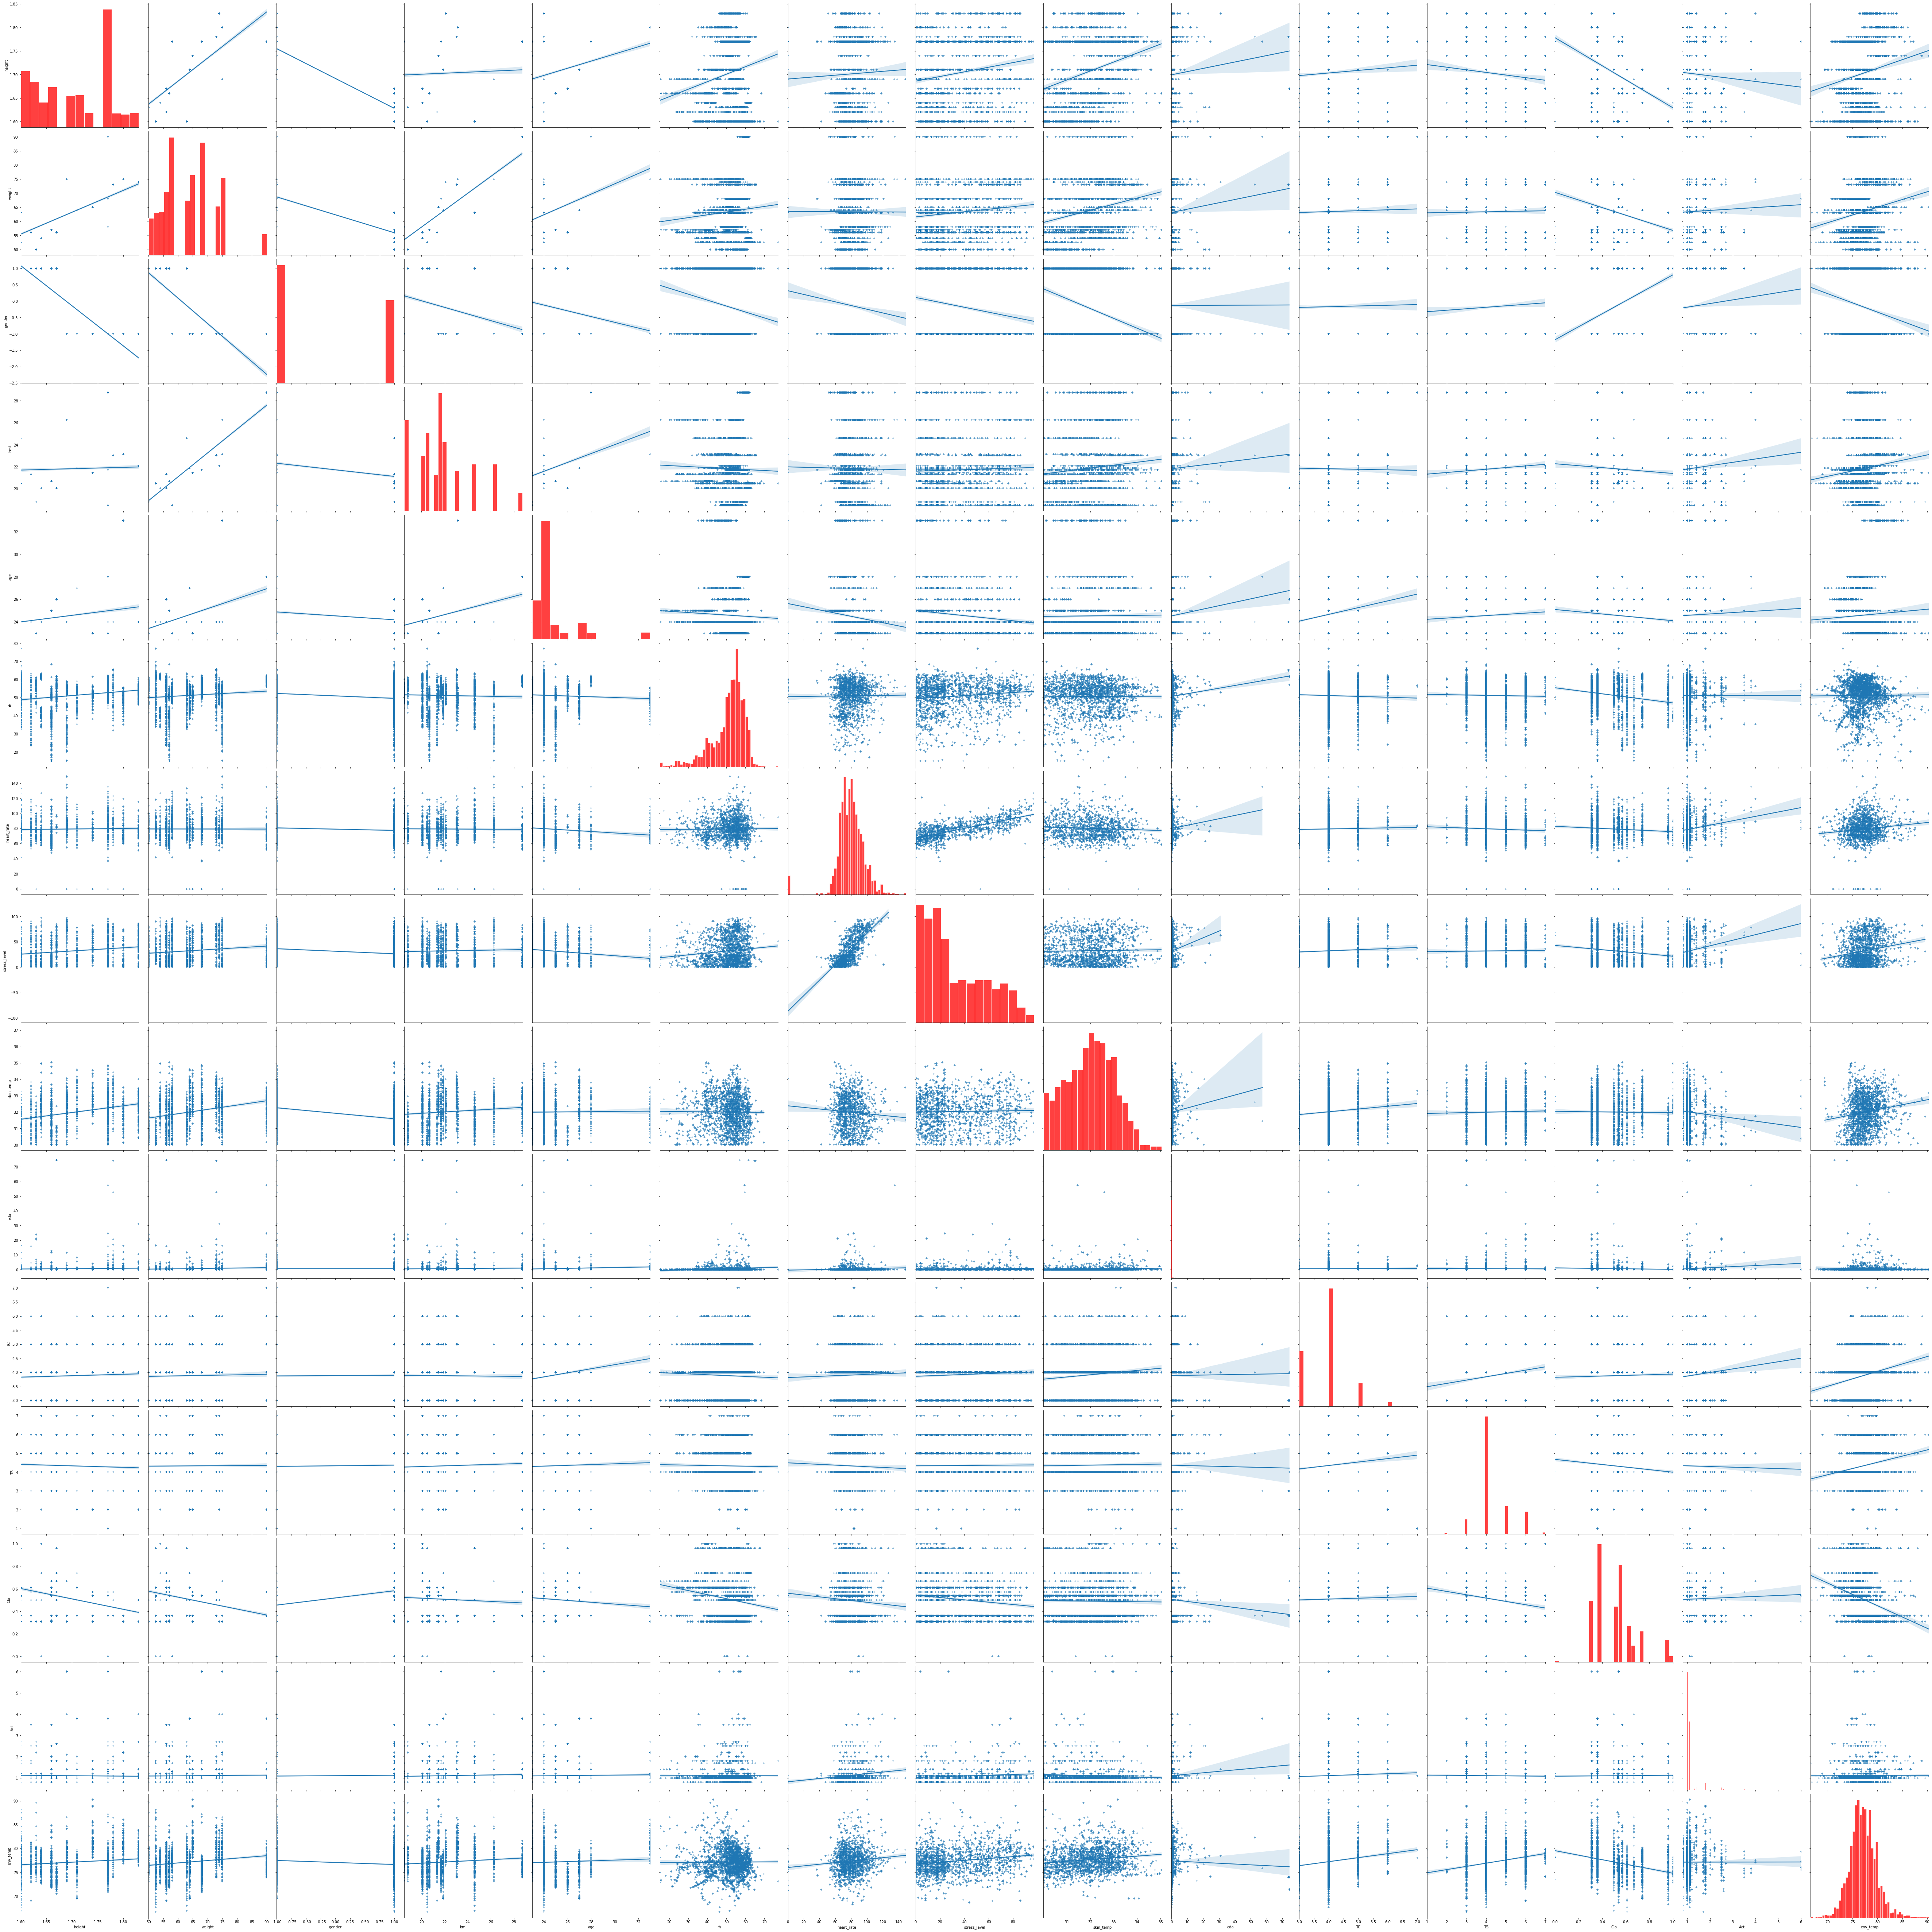

In [13]:
sns.pairplot(df_visual, dropna=True, kind='reg', markers='+', height=5, aspect=1,
            diag_kws=dict(edgecolor="w", color="r"))

#### correlation map

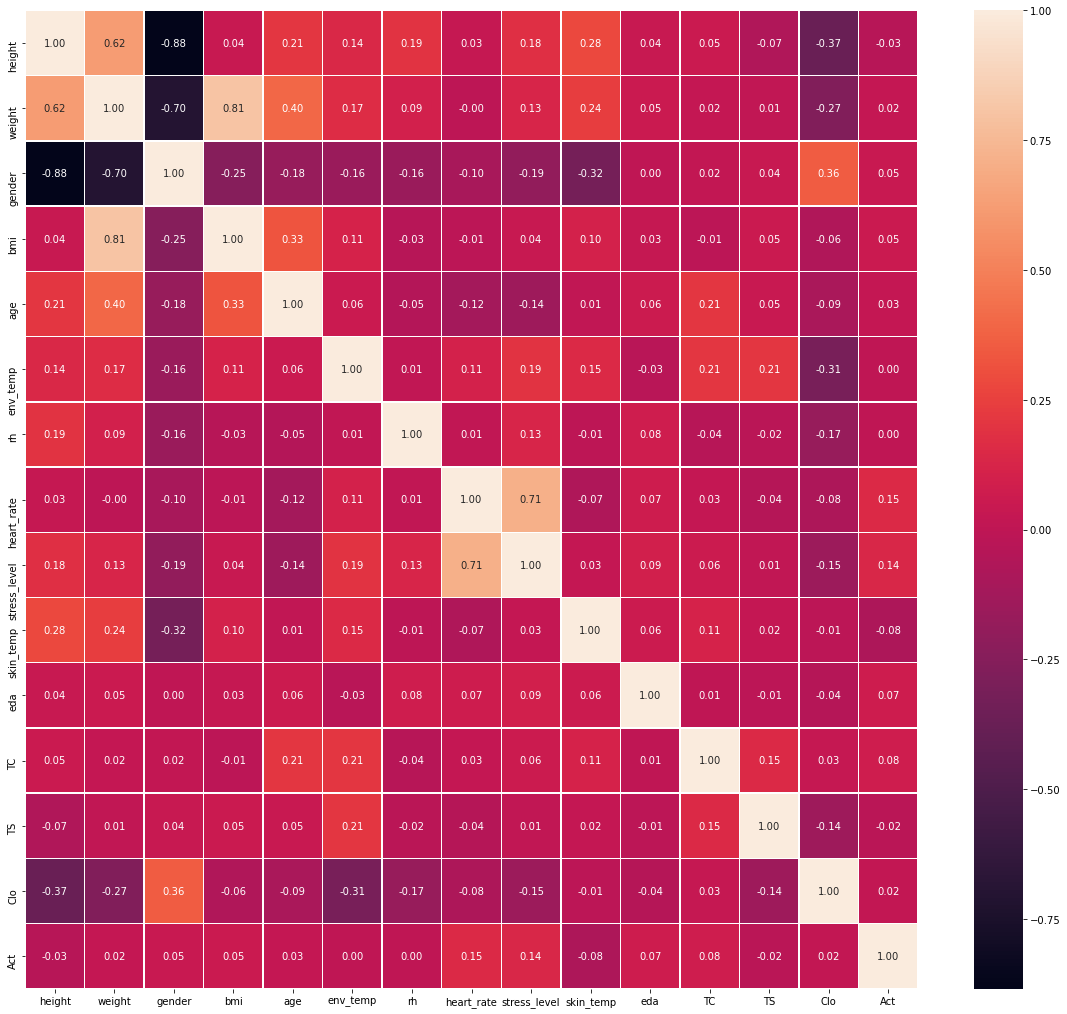

In [14]:
# correlation map
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(df_comfort.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### shuffle

In [15]:
df_shuffle = df_comfort.sample(frac=1, random_state=1208).reset_index(drop=True)

In [16]:
X_data = df_shuffle[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'TC', 'TS', 'Clo', 'Act']]

In [17]:
X_cols_name = X_data.columns

In [18]:
y_data = df_shuffle['env_temp']

### imputation

In [19]:
df_record[df_record[['env_temp']].isna().env_temp]
# no na in env_temp

Empty DataFrame
Columns: [time, height, weight, gender, bmi, age, env_temp, rh, heart_rate, stress_level, skin_temp, eda, TC, TS, Clo, Act]
Index: []

In [20]:
imp = SimpleImputer(strategy='mean')

In [21]:
X_data = pd.DataFrame(imp.fit_transform(X_data), columns=X_cols_name)

In [22]:
X_data

height  weight  gender        bmi   age      rh  heart_rate  \
0       1.60    52.5     1.0  20.507812  24.0  62.985   83.000000   
1       1.77    58.0    -1.0  18.513199  23.0  48.702   79.000000   
2       1.71    64.0    -1.0  21.887076  27.0  47.990   79.333991   
3       1.77    58.0    -1.0  18.513199  23.0  52.445   92.000000   
4       1.77    58.0    -1.0  18.513199  23.0  56.396   79.333991   
...      ...     ...     ...        ...   ...     ...         ...   
2523    1.66    57.0     1.0  20.685150  25.0  52.940   79.333991   
2524    1.69    75.0    -1.0  26.259585  24.0  47.010   79.333991   
2525    1.60    63.0     1.0  24.609375  24.0  45.760  105.000000   
2526    1.74    65.0    -1.0  21.469150  23.0  53.640   79.333991   
2527    1.60    52.5     1.0  20.507812  24.0  52.443   75.000000   

      stress_level  skin_temp       eda   TC   TS   Clo  Act  
0        19.500000  32.003449  0.176971  4.0  4.0  0.61  1.1  
1         2.000000  30.933000  0.038822  4.0  4.0  0.36  1.1  
2        33.000000  33.199000  0.475946  4.0  4.0  0.61  1.0  
3        53.000000  30.431000  0.009852  4.0  4.0  0.36  1.0  
4        80.000000  30.087000  0.003597  4.0  4.0  0.36  1.0  
...            ...        ...       ...  ...  ...   ...  ...  
2523      2.000000  30.854000  0.008716  4.0  4.0  0.54  1.0  
2524     32.111013  31.300000  0.025626  3.0  4.0  0.36  1.0  
2525     32.111013  32.003449  0.013018  4.0  4.0  0.50  1.1  
2526     32.111013  34.150000  0.131368  4.0  7.0  0.54  0.8  
2527     20.000000  30.669000  0.046915  4.0  4.0  0.96  1.1  

[2528 rows x 14 columns]

### normalize

In [23]:
X_array_normalize, X_norm = normalize(X_data, axis=0, return_norm=True)

In [24]:
X_data = pd.DataFrame(X_array_normalize, columns=X_cols_name)

In [25]:
X_data

height    weight    gender       bmi       age        rh  heart_rate  \
0     0.018674  0.016305  0.019889  0.018573  0.019347  0.024127    0.020524   
1     0.020659  0.018013 -0.019889  0.016766  0.018541  0.018656    0.019535   
2     0.019958  0.019877 -0.019889  0.019822  0.021765  0.018383    0.019618   
3     0.020659  0.018013 -0.019889  0.016766  0.018541  0.020090    0.022750   
4     0.020659  0.018013 -0.019889  0.016766  0.018541  0.021603    0.019618   
...        ...       ...       ...       ...       ...       ...         ...   
2523  0.019375  0.017703  0.019889  0.018733  0.020153  0.020279    0.019618   
2524  0.019725  0.023293 -0.019889  0.023782  0.019347  0.018008    0.019618   
2525  0.018674  0.019566  0.019889  0.022287  0.019347  0.017529    0.025964   
2526  0.020308  0.020188 -0.019889  0.019443  0.018541  0.020548    0.019618   
2527  0.018674  0.016305  0.019889  0.018573  0.019347  0.020089    0.018546   

      stress_level  skin_temp       eda        TC        TS       Clo  \
0         0.010107   0.019882  0.000866  0.020182  0.018018  0.022576   
1         0.001037   0.019217  0.000190  0.020182  0.018018  0.013323   
2         0.017104   0.020624  0.002329  0.020182  0.018018  0.022576   
3         0.027470   0.018905  0.000048  0.020182  0.018018  0.013323   
4         0.041464   0.018691  0.000018  0.020182  0.018018  0.013323   
...            ...        ...       ...       ...       ...       ...   
2523      0.001037   0.019168  0.000043  0.020182  0.018018  0.019985   
2524      0.016643   0.019445  0.000125  0.015137  0.018018  0.013323   
2525      0.016643   0.019882  0.000064  0.020182  0.018018  0.018505   
2526      0.016643   0.021215  0.000643  0.020182  0.031532  0.019985   
2527      0.010366   0.019053  0.000230  0.020182  0.018018  0.035529   

           Act  
0     0.018588  
1     0.018588  
2     0.016898  
3     0.016898  
4     0.016898  
...        ...  
2523  0.016898  
2524  0.016898  
2525  0.018588  
2526  0.013519  
2527  0.018588  

[2528 rows x 14 columns]

In [26]:
X_norm

array([  85.67889413, 3219.80907819,   50.27922036, 1104.20171125,
       1240.52690418, 2610.52082164, 4044.03947436, 1929.40521588,
       1609.69440491,  204.39639127,  198.19434906,  221.99549545,
         27.02021465,   59.17786748])

### split: train & test

In [27]:
def split_into_train_test(X, y, frac=0.8):
    n_rows = y.shape[0]
    n_rows_train = int(n_rows * frac)
    # n_rows_test = n_rows - n_rows_train

    X_train = X[:n_rows_train]
    y_train = y[:n_rows_train]

    X_test = X[n_rows_train:]
    y_test = y[n_rows_train:]
    return X_train, y_train, X_test, y_test

In [28]:
n_rows = y_data.shape[0]

In [29]:
train_test_fraction = 0.8
n_rows_train = int(n_rows * train_test_fraction)
# n_rows_test = n_rows - n_rows_train

In [30]:
X_train = X_data[:n_rows_train]
y_train = y_data[:n_rows_train]

In [31]:
X_test = X_data[n_rows_train:]
y_test = y_data[n_rows_train:]

## linear regression (1st try)

### single linear regression
env_temp = f(each feature individually)

In [32]:
n_features = X_train.shape[1]

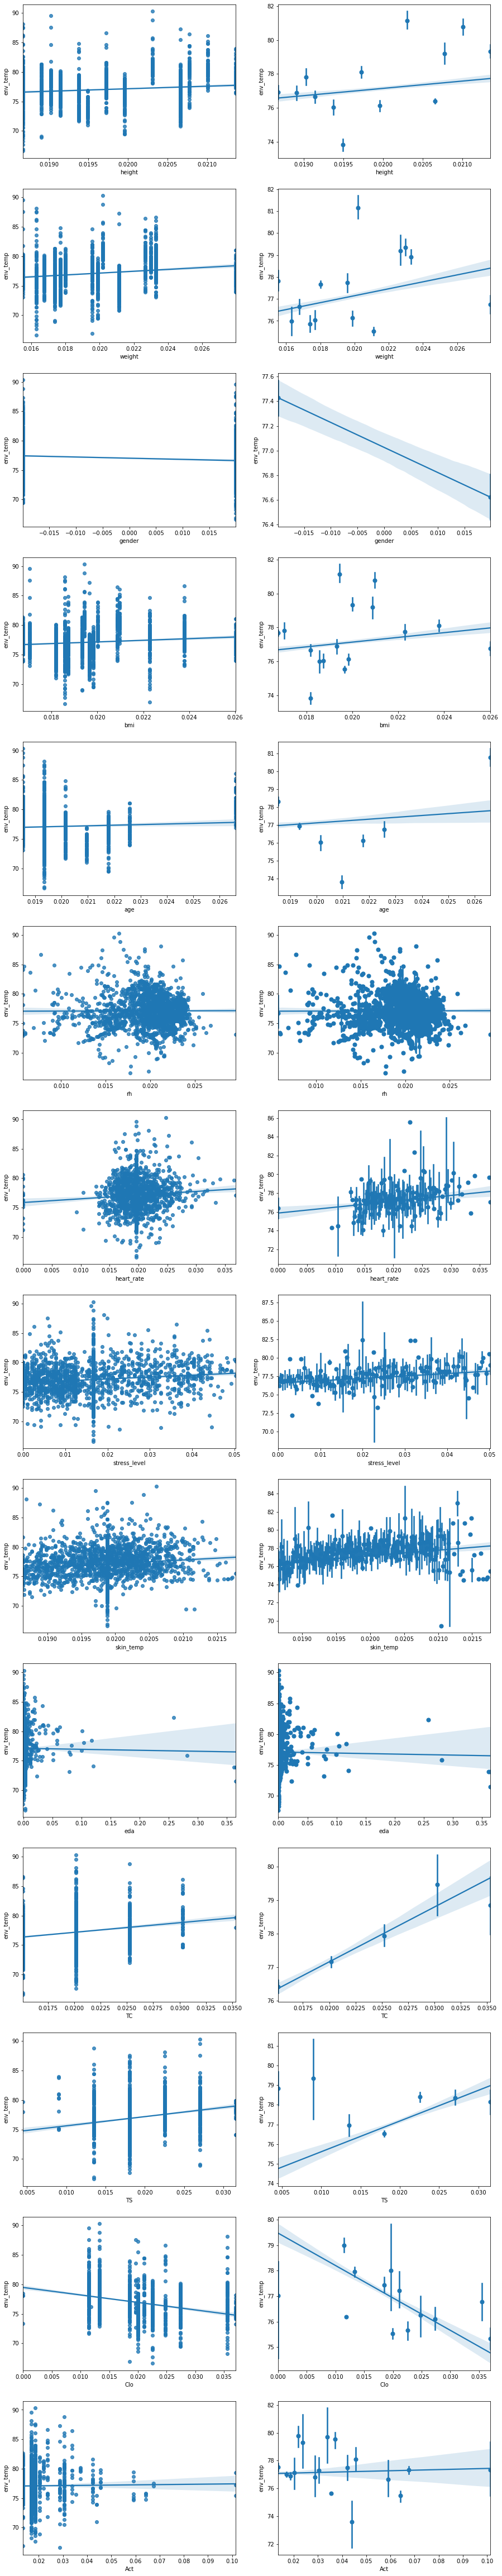

In [33]:
plt.figure(figsize=(15, 6*n_features))
i = 1
for col_n in X_train.columns:
    # left
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train)
    i += 1
    
    # right
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train, x_estimator=np.mean)
    i += 1

### multiple linear regression
env_temp = f(all features together)

In [34]:
regr = sm.OLS(y_train, X_train)

In [35]:
regr_fit = regr.fit()

In [36]:
y_pred = regr_fit.predict(X_test)

In [37]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Actual  Predicted
2022  80.029  79.755062
2023  78.449  77.535114
2024  77.050  77.583644
2025  77.574  77.728414
2026  77.923  77.648144
...      ...        ...
2523  76.703  76.231979
2524  75.484  77.207694
2525  71.683  77.995978
2526  79.151  79.022514
2527  86.211  74.148339

[506 rows x 2 columns]

In [38]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.455e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        12:39:55   Log-Likelihood:                         -4656.7
No. Observations:                2022   AIC:                                      9341.
Df Residuals:                    2008   BIC:                                      9420.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3122.1334    115.412     27.052      0.000    2895.793    3348.474
weight       -1456.8403     91.206    -15.973      0.000   -1635.708   -1277.972
gender          11.7767      6.391      1.843      0.066      -0.756      24.310
bmi           1581.8579     84.714     18.673      0.000    1415.721    1747.995
age            -10.7254     39.903     -0.269      0.788     -88.980      67.529
rh             -20.5490     17.095     -1.202      0.229     -54.074      12.976
heart_rate      28.6172     18.235      1.569      0.117      -7.145      64.380
stress_level    18.7819      5.543      3.388      0.001       7.911      29.652
skin_temp      468.7197    106.159      4.415      0.000     260.527     676.913
eda             -4.6092      3.007     -1.533      0.126     -10.507       1.289
TC             145.0245     16.442      8.820      0.000     112.779     177.270
TS             116.6967     14.544      8.024      0.000      88.175     145.219
Clo           -114.5739      9.218    -12.429      0.000    -132.652     -96.495
Act             -0.4285      8.431     -0.051      0.959     -16.963      16.106
==============================================================================
Omnibus:                      226.279   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              755.321
Skew:                           0.545   Prob(JB):                    9.64e-165
Kurtosis:                       5.788   Cond. No.                         218.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# mean squared error
mean_squared_error(y_test, y_pred)

6.431952139818991

In [40]:
# R2 score
r2_score(y_test, y_pred)

0.1800772209791961

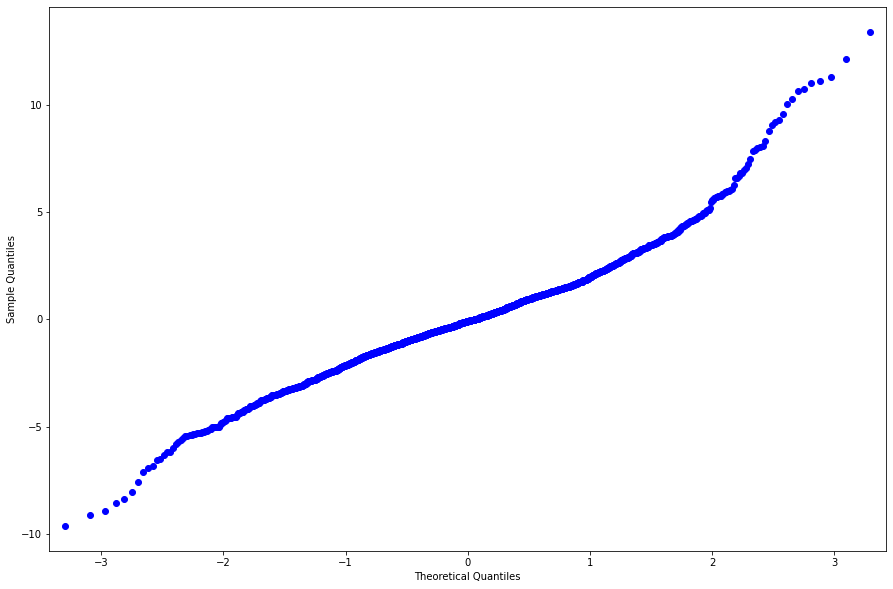

In [41]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.qqplot(regr_fit.resid)
plt.show()

## refine data

In [42]:
regr = sm.OLS(y_data, X_data)
regr_fit = regr.fit()

### leverage & outlier

In [43]:
infl = regr_fit.get_influence()

In [44]:
# leverage
leviers = infl.hat_matrix_diag
# list(leviers)

In [45]:
# studentized residue
res_studs = infl.resid_studentized_external
# list(res_studs)

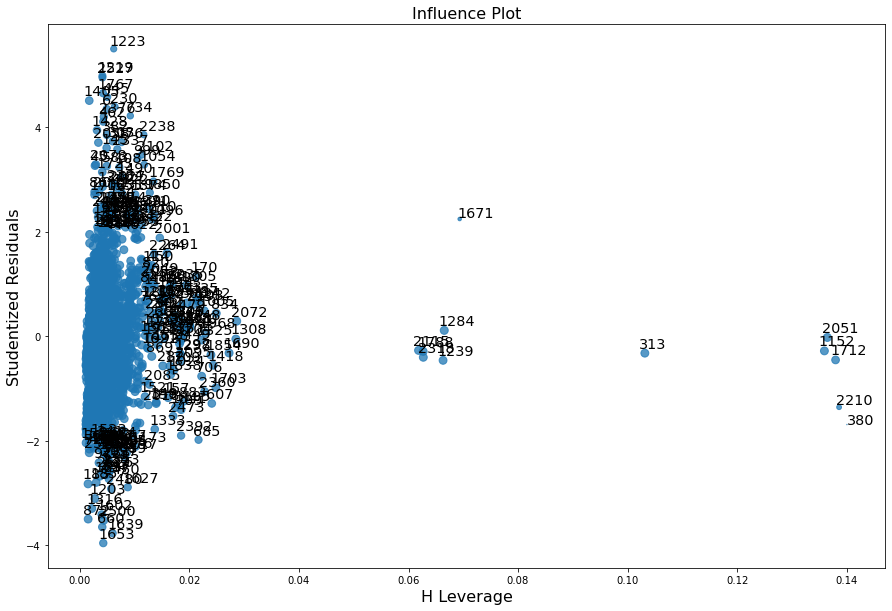

In [46]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.graphics.influence_plot(regr_fit, size=0.5)
plt.show()

### leverage detection
the threshold value may be:
$$s_h=2\times \frac{p+1}{n}$$

In [47]:
n_data = X_data.shape[0]
p_data = X_data.shape[1]

In [48]:
s_h = 2 * (p_data + 1) / n_data
s_h

0.011867088607594937

In [49]:
atyp_levier = leviers > s_h

In [50]:
X_data.index[atyp_levier]

Int64Index([  31,   76,  112,  114,  135,  157,  159,  168,  170,  210,
            ...
            2318, 2320, 2356, 2360, 2380, 2392, 2449, 2473, 2479, 2491],
           dtype='int64', length=113)

In [51]:
leviers[atyp_levier]

array([0.01838078, 0.01197112, 0.01474587, 0.01249473, 0.02133873,
       0.01608223, 0.01391813, 0.02011088, 0.02116925, 0.01356355,
       0.01405329, 0.01285551, 0.01513958, 0.10315783, 0.01392717,
       0.14006007, 0.01262071, 0.0148009 , 0.01316149, 0.01949371,
       0.01526971, 0.01725428, 0.02407374, 0.01451226, 0.02165301,
       0.01504775, 0.0222203 , 0.01847472, 0.01901569, 0.02145082,
       0.01238749, 0.02488614, 0.0120058 , 0.01311068, 0.01853997,
       0.01902174, 0.01392726, 0.02269228, 0.01709469, 0.01506922,
       0.01321366, 0.01260394, 0.01537795, 0.13594907, 0.01831138,
       0.01200687, 0.06630801, 0.0218374 , 0.01657584, 0.06652577,
       0.01831424, 0.01833023, 0.01936446, 0.02847014, 0.02220994,
       0.01365543, 0.01538538, 0.01417905, 0.01193338, 0.02432077,
       0.01325603, 0.01188932, 0.01243592, 0.01419237, 0.01232973,
       0.06934173, 0.02722924, 0.02481054, 0.01847026, 0.01308911,
       0.01643346, 0.13798966, 0.02005248, 0.0126596 , 0.01342

In [52]:
len(leviers[atyp_levier])

113

### outlier detection
Threshold:
$$s_t=t_{1-0.05/2}(n-p-2)$$

In [53]:
seuil_stud = scipy.stats.t.ppf(0.975, df=n_data-p_data-2)
seuil_stud

1.9609088074865402

In [54]:
atyp_stud = np.abs(res_studs) > seuil_stud
atyp_stud

array([False, False, False, ...,  True, False,  True])

In [55]:
X_data.index[atyp_stud]

Int64Index([   6,   45,   61,   86,  106,  108,  129,  134,  144,  145,
            ...
            2442, 2450, 2460, 2476, 2480, 2484, 2486, 2500, 2525, 2527],
           dtype='int64', length=135)

In [56]:
res_studs[atyp_stud]

array([ 4.35190113,  3.2670872 , -2.59703345,  2.76895227,  2.29570096,
        3.23513247, -2.51290125,  2.59560883, -2.05575103,  3.60685045,
       -2.03662247,  3.71527651, -2.82240496,  2.08818374,  2.31685612,
        4.39356517,  2.31284653,  2.02924638, -2.22550873, -2.38612793,
       -2.09227137,  3.7309549 , -1.98782807, -2.06599464,  3.85491477,
        2.43654355,  2.32775006,  1.97395378,  4.58089831,  2.3624019 ,
       -2.19104172,  4.10926422, -2.1403123 , -2.567503  , -2.22066793,
       -2.19123549,  3.25967958, -2.03366195,  1.9715293 , -2.01573634,
       -2.21569619, -3.64721279, -1.97919374, -2.32166762, -2.15552823,
        4.22095341, -2.07156589,  2.3188232 ,  2.02290049, -2.64825612,
       -3.49610635, -2.15707827, -2.41830245,  3.39798212,  2.06309031,
        3.28642231,  2.09262533,  2.24308325, -2.07611978, -2.10817865,
       -3.10270085, -2.23085943,  4.98679349,  5.50097846, -3.29367277,
        2.86236115,  2.71478676,  1.98383259,  4.51159863,  3.94

In [57]:
len(res_studs[atyp_stud])

135

In [58]:
idx_eliminate_lvg_outl = np.logical_not(np.logical_or(atyp_levier, atyp_stud))

In [59]:
X_data.index[idx_eliminate_lvg_outl]

Int64Index([   0,    1,    2,    3,    4,    5,    7,    8,    9,   10,
            ...
            2516, 2517, 2518, 2519, 2520, 2521, 2522, 2523, 2524, 2526],
           dtype='int64', length=2287)

In [60]:
X_data_refine = X_data[idx_eliminate_lvg_outl]
y_data_refine = y_data[idx_eliminate_lvg_outl]

## linear regression (2nd try)

In [61]:
n_rows = y_data_refine.shape[0]

train_test_fraction = 0.8
n_rows_train = int(n_rows * train_test_fraction)
# n_rows_test = n_rows - n_rows_train

X_train = X_data_refine[:n_rows_train]
y_train = y_data_refine[:n_rows_train]

X_test = X_data_refine[n_rows_train:]
y_test = y_data_refine[n_rows_train:]

In [62]:
regr = sm.OLS(y_train, X_train)

In [63]:
regr_fit = regr.fit()

In [64]:
y_pred = regr_fit.predict(X_test)

In [65]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Actual  Predicted
2016  80.735  79.604315
2017  76.507  77.536903
2019  78.624  78.896832
2020  78.800  78.616217
2021  81.090  78.768120
...      ...        ...
2521  74.467  77.001469
2522  73.753  75.661208
2523  76.703  76.148378
2524  75.484  77.113602
2526  79.151  79.262696

[458 rows x 2 columns]

In [66]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.187e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        12:40:05   Log-Likelihood:                         -3744.7
No. Observations:                1829   AIC:                                      7517.
Df Residuals:                    1815   BIC:                                      7595.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3103.0217     97.652     31.776      0.000    2911.499    3294.544
weight       -1575.5115     76.599    -20.568      0.000   -1725.743   -1425.280
gender           9.9444      5.252      1.894      0.058      -0.356      20.244
bmi           1667.0839     70.956     23.495      0.000    1527.920    1806.247
age            -30.5852     34.497     -0.887      0.375     -98.244      37.073
rh              22.4294     14.428      1.555      0.120      -5.867      50.726
heart_rate      -4.2697     20.944     -0.204      0.838     -45.347      36.807
stress_level    20.6906      4.860      4.257      0.000      11.158      30.223
skin_temp      539.7111     87.332      6.180      0.000     368.430     710.992
eda             -6.4343      7.706     -0.835      0.404     -21.549       8.680
TC             113.1159     14.526      7.787      0.000      84.626     141.606
TS             137.6503     12.651     10.881      0.000     112.839     162.462
Clo           -118.7462      7.762    -15.299      0.000    -133.969    -103.523
Act             -1.1155     11.098     -0.101      0.920     -22.882      20.651
==============================================================================
Omnibus:                        3.641   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.162   Jarque-Bera (JB):                3.662
Skew:                           0.093   Prob(JB):                        0.160
Kurtosis:                       2.882   Cond. No.                         223.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# mean squared error
mean_squared_error(y_test, y_pred)

3.4474797675449467

In [68]:
# R2 score
r2_score(y_test, y_pred)

0.3042159351009851

notice that:
- MSE clearly drops.
- R2 increases a little.
- In p-value table, featrues gender, rh, eda drops a lot; features age, heart rate increases a little.

## feature selection

### correlation map for refine data

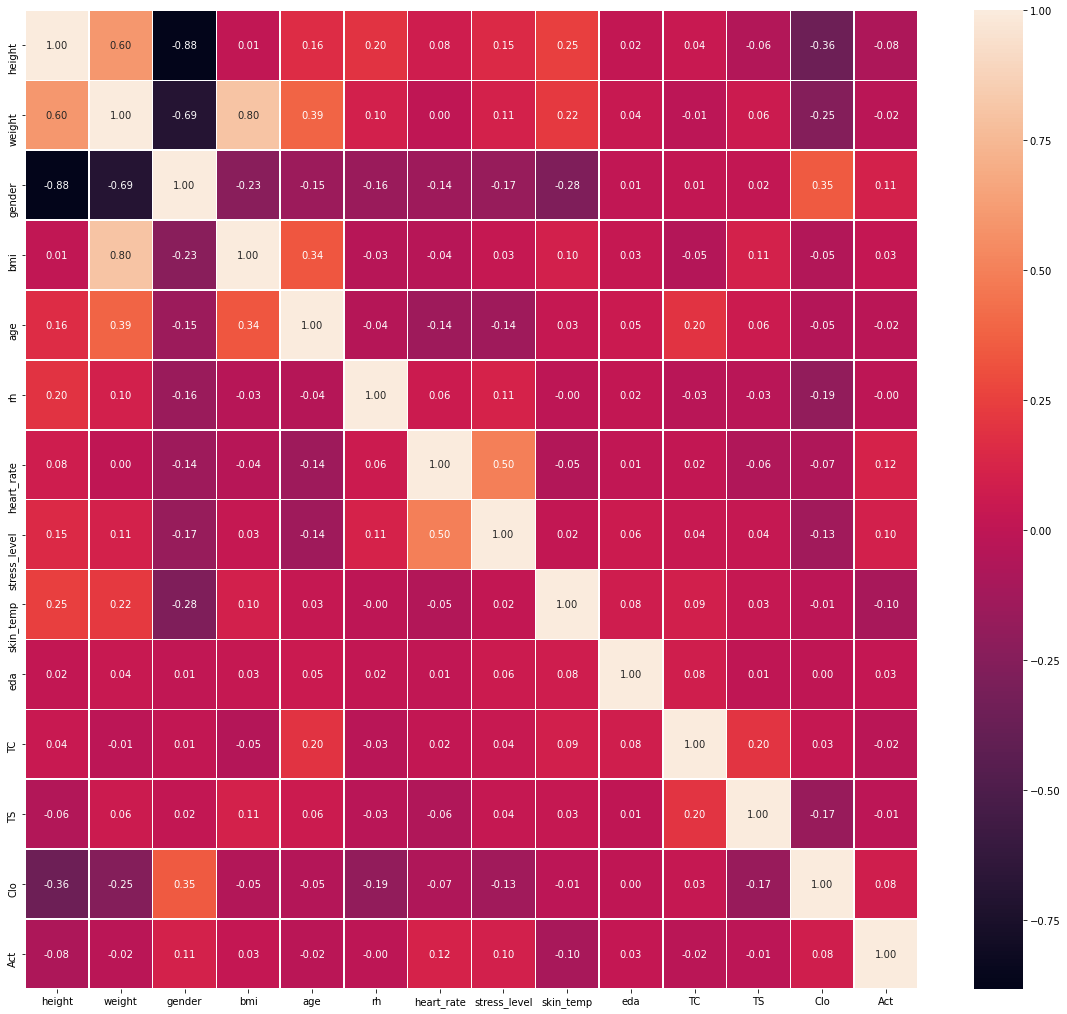

In [69]:
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(X_data_refine.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### backward selection

In [70]:
regr = sm.OLS(y_data_refine, X_data_refine)
regr_fit = regr.fit()

In [71]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.758e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        12:40:06   Log-Likelihood:                         -4675.0
No. Observations:                2287   AIC:                                      9378.
Df Residuals:                    2273   BIC:                                      9458.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3120.3694     86.916     35.901      0.000    2949.926    3290.813
weight       -1569.3440     68.293    -22.980      0.000   -1703.267   -1435.421
gender           9.4058      4.641      2.027      0.043       0.305      18.507
bmi           1654.9435     63.034     26.255      0.000    1531.332    1778.555
age            -29.8858     30.888     -0.968      0.333     -90.457      30.686
rh              28.5008     12.745      2.236      0.025       3.509      53.493
heart_rate     -13.6848     18.635     -0.734      0.463     -50.228      22.858
stress_level    23.9767      4.271      5.614      0.000      15.602      32.351
skin_temp      547.5106     77.583      7.057      0.000     395.370     699.651
eda              3.2009      7.075      0.452      0.651     -10.673      17.075
TC             109.9957     13.043      8.433      0.000      84.418     135.574
TS             129.6056     11.204     11.568      0.000     107.634     151.577
Clo           -121.1534      6.887    -17.592      0.000    -134.659    -107.648
Act             -9.2039      9.658     -0.953      0.341     -28.143       9.735
==============================================================================
Omnibus:                        5.849   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                5.853
Skew:                           0.110   Prob(JB):                       0.0536
Kurtosis:                       2.885   Cond. No.                         224.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
X_rm = X_data_refine

start to remove features

#### remove eda

In [75]:
X_rm = X_rm.drop(columns='eda')

In [76]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.971e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        13:17:33   Log-Likelihood:                         -4675.1
No. Observations:                2287   AIC:                                      9376.
Df Residuals:                    2274   BIC:                                      9451.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3116.1037     86.388     36.071      0.000    2946.695    3285.512
weight       -1565.6111     67.781    -23.098      0.000   -1698.530   -1432.692
gender           9.5756      4.625      2.070      0.039       0.506      18.645
bmi           1651.6986     62.614     26.379      0.000    1528.912    1774.486
age            -29.5383     30.873     -0.957      0.339     -90.081      31.004
rh              28.5872     12.741      2.244      0.025       3.602      53.572
heart_rate     -13.6153     18.631     -0.731      0.465     -50.150      22.920
stress_level    24.0814      4.264      5.648      0.000      15.721      32.442
skin_temp      550.6926     77.250      7.129      0.000     399.205     702.180
TC             110.3729     13.014      8.481      0.000      84.852     135.894
TS             129.4988     11.200     11.563      0.000     107.536     151.462
Clo           -121.1581      6.886    -17.596      0.000    -134.661    -107.655
Act             -9.1049      9.654     -0.943      0.346     -28.036       9.826
==============================================================================
Omnibus:                        5.890   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.894
Skew:                           0.110   Prob(JB):                       0.0525
Kurtosis:                       2.885   Cond. No.                         222.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove heart rate

In [77]:
X_rm = X_rm.drop(columns='heart_rate')

In [78]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.219e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        13:18:08   Log-Likelihood:                         -4675.3
No. Observations:                2287   AIC:                                      9375.
Df Residuals:                    2275   BIC:                                      9443.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3096.7109     82.203     37.671      0.000    2935.510    3257.912
weight       -1549.5626     64.118    -24.167      0.000   -1675.299   -1423.826
gender          10.2071      4.543      2.247      0.025       1.298      19.116
bmi           1637.3556     59.453     27.541      0.000    1520.769    1753.943
age            -28.9661     30.860     -0.939      0.348     -89.483      31.550
rh              28.4976     12.739      2.237      0.025       3.516      53.479
stress_level    22.6198      3.765      6.008      0.000      15.237      30.003
skin_temp      556.1049     76.886      7.233      0.000     405.331     706.879
TC             109.9905     13.002      8.459      0.000      84.493     135.488
TS             130.1154     11.167     11.652      0.000     108.217     152.014
Clo           -121.0909      6.884    -17.589      0.000    -134.591    -107.591
Act             -9.7869      9.608     -1.019      0.308     -28.627       9.053
==============================================================================
Omnibus:                        6.138   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                6.128
Skew:                           0.112   Prob(JB):                       0.0467
Kurtosis:                       2.880   Cond. No.                         203.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove age

In [79]:
X_rm = X_rm.drop(columns='age')

In [80]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.512e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        13:18:31   Log-Likelihood:                         -4675.8
No. Observations:                2287   AIC:                                      9374.
Df Residuals:                    2276   BIC:                                      9437.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3076.0354     79.195     38.841      0.000    2920.733    3231.337
weight       -1554.2272     63.924    -24.314      0.000   -1679.582   -1428.872
gender           9.3212      4.444      2.098      0.036       0.607      18.036
bmi           1633.3052     59.294     27.546      0.000    1517.029    1749.582
rh              29.1435     12.720      2.291      0.022       4.199      54.088
stress_level    23.2577      3.703      6.281      0.000      15.996      30.519
skin_temp      557.8901     76.860      7.258      0.000     407.166     708.614
TC             107.3735     12.700      8.455      0.000      82.469     132.278
TS             130.0551     11.166     11.647      0.000     108.158     151.952
Clo           -121.1574      6.884    -17.600      0.000    -134.657    -107.658
Act             -9.7012      9.607     -1.010      0.313     -28.540       9.138
==============================================================================
Omnibus:                        5.696   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.670
Skew:                           0.105   Prob(JB):                       0.0587
Kurtosis:                       2.877   Cond. No.                         192.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove Act

In [81]:
X_rm = X_rm.drop(columns='Act')

In [82]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.863e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        13:18:44   Log-Likelihood:                         -4676.3
No. Observations:                2287   AIC:                                      9373.
Df Residuals:                    2277   BIC:                                      9430.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3063.3454     78.192     39.177      0.000    2910.010    3216.680
weight       -1552.1393     63.891    -24.294      0.000   -1677.429   -1426.849
gender           8.7978      4.414      1.993      0.046       0.143      17.453
bmi           1629.4979     59.174     27.537      0.000    1513.456    1745.539
rh              29.0763     12.720      2.286      0.022       4.132      54.020
stress_level    22.7955      3.675      6.203      0.000      15.589      30.001
skin_temp      564.0294     76.620      7.361      0.000     413.777     714.282
TC             107.7202     12.695      8.485      0.000      82.825     132.615
TS             130.0303     11.166     11.645      0.000     108.133     151.928
Clo           -121.6697      6.865    -17.723      0.000    -135.132    -108.207
==============================================================================
Omnibus:                        5.700   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.058   Jarque-Bera (JB):                5.672
Skew:                           0.105   Prob(JB):                       0.0587
Kurtosis:                       2.876   Cond. No.                         182.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### correlation map for selected data

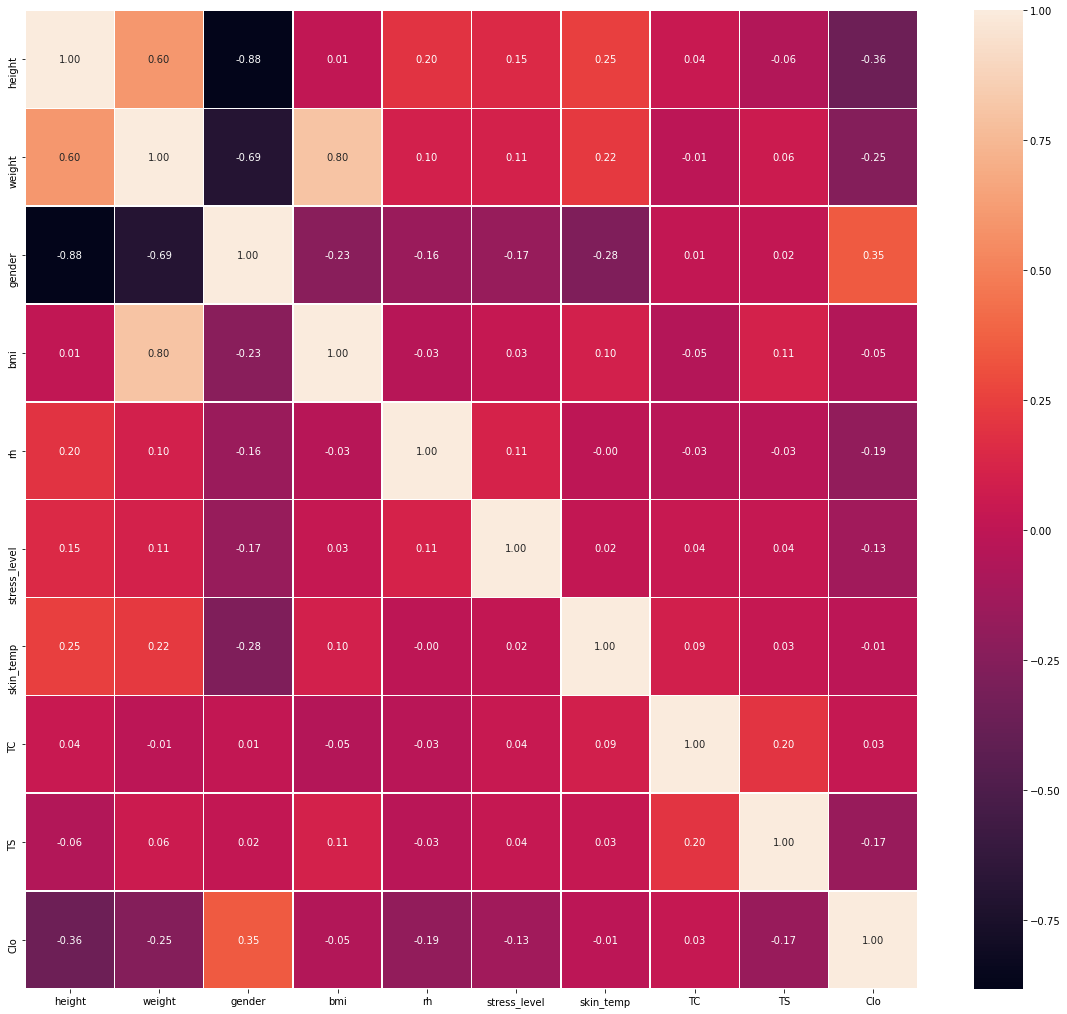

In [83]:
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(X_rm.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

## linear regression (3rd try)

### single linear regression

In [84]:
X_train, y_train, X_test, y_test = split_into_train_test(X_rm, y_data_refine)

In [85]:
n_features = X_train.shape[1]

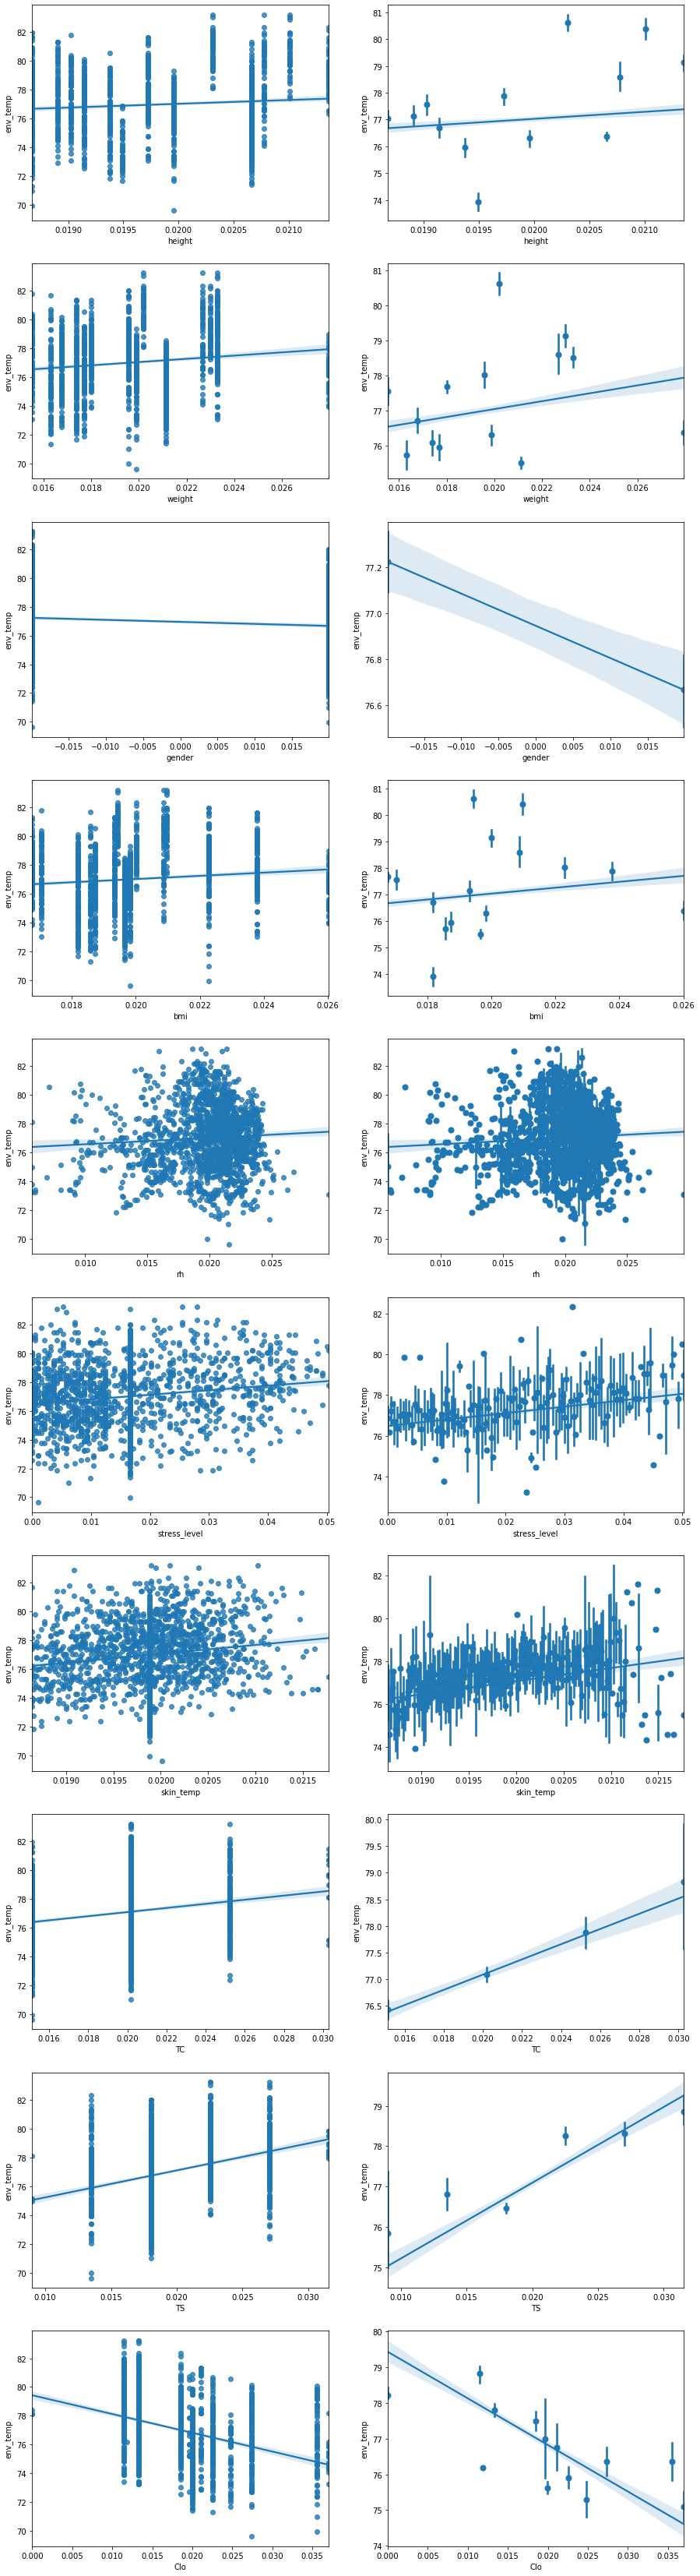

In [86]:
plt.figure(figsize=(15, 6*n_features))
i = 1
for col_n in X_train.columns:
    # left
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train)
    i += 1
    
    # right
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train, x_estimator=np.mean)
    i += 1

### multiple linear regression

In [87]:
regr = sm.OLS(y_train, X_train)

In [88]:
regr_fit = regr.fit()

In [89]:
y_pred = regr_fit.predict(X_test)

In [90]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Actual  Predicted
2016  80.735  79.577987
2017  76.507  77.524210
2019  78.624  78.881930
2020  78.800  78.679279
2021  81.090  78.728007
...      ...        ...
2521  74.467  76.997642
2522  73.753  75.742645
2523  76.703  76.145352
2524  75.484  77.086075
2526  79.151  79.219410

[458 rows x 2 columns]

In [91]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          3.066e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        13:20:00   Log-Likelihood:                         -3745.5
No. Observations:                1829   AIC:                                      7511.
Df Residuals:                    1819   BIC:                                      7566.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height        3079.7031     87.528     35.185      0.000    2908.037    3251.369
weight       -1581.3337     71.416    -22.143      0.000   -1721.400   -1441.268
gender           8.7883      4.981      1.764      0.078      -0.980      18.557
bmi           1662.5359     66.436     25.024      0.000    1532.236    1792.836
rh              22.7684     14.390      1.582      0.114      -5.455      50.992
stress_level    20.6152      4.179      4.933      0.000      12.419      28.811
skin_temp      540.0475     86.255      6.261      0.000     370.878     709.217
TC             109.3937     14.118      7.749      0.000      81.705     137.082
TS             137.8603     12.599     10.942      0.000     113.150     162.571
Clo           -118.8034      7.735    -15.359      0.000    -133.974    -103.633
==============================================================================
Omnibus:                        3.413   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.181   Jarque-Bera (JB):                3.421
Skew:                           0.086   Prob(JB):                        0.181
Kurtosis:                       2.877   Cond. No.                         182.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [92]:
# mean squared error
mean_squared_error(y_test, y_pred)

3.4332825178728648

In [93]:
# R2 score
r2_score(y_test, y_pred)

0.30708128044114413

## cross validation

In [94]:
from sklearn import metrics
# metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [95]:
lr = LinearRegression()
lr_cv_mse = cross_val_score(lr, X_rm, y_data_refine, scoring='neg_mean_squared_error', cv=10)

In [96]:
lr_cv_mse

array([-3.66862361, -3.47688245, -3.17060045, -3.64418031, -3.97568865,
       -3.41915283, -3.25075884, -3.73676276, -3.56763545, -3.31634661])

In [100]:
np.abs(lr_cv_mse.mean())

3.522663195693448

In [98]:
lr_cv_r2 = cross_val_score(lr, X_rm, y_data_refine, scoring='r2', cv=10)

In [99]:
lr_cv_r2.mean()

0.2774670412076263